In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
num_visible = 8
num_hidden = 2

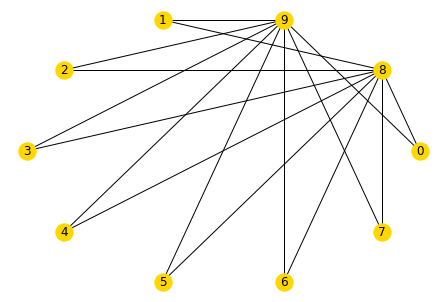

In [3]:
visible = [i for i in range(num_visible)]
hidden = [num_visible + j for j in range(num_hidden)]
edges = [(i, j) for i in visible for j in hidden]

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_circular(G, with_labels=True, node_color='gold')

In [4]:
from active_coresets.pamc_qbm import PAMC_QBM

In [25]:
import importlib
import active_coresets
importlib.reload(active_coresets.qmc_tim_qbm)
importlib.reload(active_coresets.pamc_qbm)
from active_coresets.pamc_qbm import PAMC_QBM
from active_coresets.qmc_tim_qbm import QMC_TIM_QBM
import scipy.stats as stats

In [6]:
import tensorflow as tf

In [9]:
def mixed_bernoulli(N, q, dim):
    def dist(bits1, bits2):
        d = 0
        for i in range(len(bits1)):
            if bits1[i] != bits2[i]:
                d += 1
        return d

    data_range = np.zeros((2 ** dim, dim))
    for d in range(2**dim):
        binary = format(d, "b")
        for i, b in enumerate(binary[::-1]):
            data_range[d, dim-1-i] = int(b)
    
    modes = np.random.randint(0, 2, size=(N, dim))
    b_dist = {}
    for data in data_range:
        prob = 0.0
        for i in range(N):
            d = dist(data, modes[i])
            prob += np.power(q, d) * np.power(1 - q, dim - d)
        b_dist[tuple(data)] = prob / N
    return b_dist


In [10]:
def sample_dist(num_samples, dist):
    samples = []
    for s in range(num_samples):
        rand = np.random.rand()
        prob_total = 0.0
        for data, prob in dist.items():
            prob_total += prob
            if prob_total > rand:
                samples.append(data)
                break
    return np.array(samples)

In [11]:
def data_to_dict(data):
    dict = {}
    for z_pt in data:
        bitstring = ''.join(['0' if b == 1 else '1' for b in z_pt])
        pt = int(bitstring, 2)
        if pt in dict:
            dict[pt] += 1
        else:
            dict[pt] = 1
    return {k: v / sum(dict.values()) for k, v in dict.items()}

def data_to_dist(data):
    dict = data_to_dict(data)
    dist = np.zeros(2**data.shape[1])
    for i in range(dist.shape[0]):
        if i in dict:
            dist[i] = dict[i]
        else:
            dist[i] = 1e-5
    return dist

In [12]:
b_dist = mixed_bernoulli(8, 0.9, num_visible)

In [13]:
num_samples = 2048
b_data = -2 * sample_dist(num_samples, b_dist) + np.ones((num_samples, num_visible))

In [ ]:
pamc_qbm = PAMC_QBM(visible, hidden, gamma=2, population_size=256)
pop_history = pamc_qbm.train(b_data.astype(np.float32), epochs=4, batch_size=10, betas=np.linspace(0,10,5).astype(np.float32), num_its=10, learning_rate=0.01, exact=True, v_interval=1, debug=True)

In [14]:
results_path = "results"

In [31]:
test_params = {'replicas': [64, 128, 512], 'its': [10], 'betas': [1]}
tests = []
for replicas in test_params['replicas']:
    for its in test_params['its']:
        for betas in test_params['betas']:
            tests.append({'replicas': replicas, 'its': its, 'beta': betas})


In [17]:
gamma = 2.0

In [34]:
init_biases = np.random.normal(scale=.01, size=(len(visible) + len(hidden))).astype(np.float32)
init_weights = np.random.normal(scale=.01, size=(len(visible), len(hidden))).astype(np.float32)
# init_biases = np.zeros(len(visible) + len(hidden)).astype(np.float32)
# pv_biases = -0.5 * (b_data.mean(axis=0) - 1)
# init_v_biases = np.log(pv_biases / (np.ones(pv_biases.shape[0]) - pv_biases))
# init_biases[:len(visible)] = init_v_biases
gammas = np.ones(len(visible) + len(hidden)) * gamma

init_params = {'gammas': gammas.astype(np.float32),
               'biases': init_biases,
               'weights': init_weights}

In [19]:
quantum_lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(2e-3, 500, power=0.5)

params = dict(num_visible=8, num_hidden=2, num_ancilla=0,
              batch_size=32, m_b_p=0.9, m_b_m=8, num_test_samples=2048,
              qbm_optimizer=tf.optimizers.Adam(learning_rate=quantum_lr_schedule, beta_1=0.5, beta_2=0.9).get_config())

In [20]:
# set the number of mini-batches per epoch
NUM_MINI_BATCHES = 64

# set the number of epochs
NUM_EPOCHS = 4

# set the number of repetitions
NUM_REPS = 1

# set the number of training steps
NUM_TRAINS = NUM_MINI_BATCHES * NUM_EPOCHS

In [21]:
qmc_qbm_kl_divs = np.full((NUM_TRAINS), np.inf)
qmc_qbm_params = [{} for _ in range(NUM_TRAINS)]

In [22]:
test_distribution = data_to_dist(b_data)

In [7]:
from tensorflow.python.client import device_lib
tf.compat.v1.disable_eager_execution()

In [8]:
tf.config.list_physical_devices()

2022-04-13 11:24:51.418146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 11:24:51.450581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 11:24:51.450737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [28]:
def y_range(dict, x_range):
    y = []
    for x in x_range:
        if x in dict:
            y.append(dict[x])
        else:
            y.append(0)
    return y

In [36]:
for test in tests: 
    print(f'Running experiment: {test}\n')
    test_name = f"{test['replicas']}-{test['its']}-{test['beta']}"
    output_path = os.path.join(results_path, test_name)
    os.mkdir(output_path)

    tf.compat.v1.reset_default_graph()
    qmc_qbm_kl_divs = np.full((NUM_TRAINS), np.inf)
    qmc_qbm_params = [{} for _ in range(NUM_TRAINS)]
    qmc_qbm = QMC_TIM_QBM(visible, hidden, initial_params=init_params, num_its=test['its'], num_replicas=test['replicas'], betas=np.linspace(0, test['beta'], 5).astype(np.float32))

    qmc_qbm_mini_batches = QMC_TIM_QBM.mini_batch_generator(b_data.astype(np.float32), NUM_EPOCHS, batch_size=params['batch_size'])

    qmc_qbm_train_op = qmc_qbm.train_op(qmc_qbm_mini_batches, tf.optimizers.Adam.from_config(params['qbm_optimizer']))

    with tf.control_dependencies([qmc_qbm_train_op]):
        qmc_qbm_random_samples = qmc_qbm.random_samples(num_samples=params['num_test_samples'])

    with tf.compat.v1.train.MonitoredTrainingSession() as sess:
        for mini_batch_index in range(NUM_TRAINS):
            _, random_samples = sess.run([qmc_qbm_train_op, qmc_qbm_random_samples])
            model_dist = data_to_dist(random_samples[:, :params['num_visible']])
            qmc_qbm_kl_divs[mini_batch_index] = stats.entropy(model_dist, test_distribution)
            qmc_qbm_params[mini_batch_index] = sess.run(qmc_qbm.params)
            if mini_batch_index % 10 == 0:
                print(f'KL: {qmc_qbm_kl_divs[mini_batch_index]}')
    
    plt.plot(range(NUM_TRAINS), qmc_qbm_kl_divs)
    plt.xlabel('Mini-batch', fontsize=14)
    plt.ylabel('KL Divergence', fontsize=14)
    plt.title(test_name, fontsize=14)
    plt.savefig(os.path.join(output_path, 'kl_div.png'))
    
    final_dict = {}
    for i in range(model_dist.shape[0]):
        final_dict[i] = model_dist[i]

    fig, ax = plt.subplots(figsize=[15,5])

    x_range = range(2 ** len(visible))
    data_dist = data_to_dict(b_data)
    model_dist = final_dict
    width = 0.4

    m_bars = ax.bar(x_range, y_range(model_dist, x_range), color='palegreen', label=r'$P^{model}_v$', align='edge', width=width)
    d_bars = ax.bar(x_range, y_range(data_dist, x_range), color='lightsalmon', label=r'$P^{data}_v$', align='edge', width=-width)

    plt.grid(alpha=.4, linestyle='--')
    plt.legend(fontsize=14)
    plt.xlabel(r'Visible state', fontsize=14)
    plt.ylabel('Probability', fontsize=14)

    plt.savefig(os.path.join(output_path, 'dist.png'))
        

Running experiment: {'replicas': 64, 'its': 10, 'beta': 1}

INFO:tensorflow:Graph was finalized.


2022-04-13 12:11:07.220025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 12:11:07.220232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 12:11:07.220371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 12:11:07.220544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 12:11:07.220686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
KL: 3.1216219665756775
KL: 3.3766135579558663
KL: 3.6046788855401175
KL: 3.830773614778783
KL: 2.8940690779049207
KL: 3.4389120240710627
KL: 3.545105482772862
KL: 3.5511285734437177
KL: 3.914874272912254
KL: 3.8540317801744686
KL: 3.2191376614544316
KL: 3.0488856015986263
KL: 3.6822196500564757
KL: 3.280239382570014
KL: 3.080423605585584
KL: 3.9363771693676437
KL: 2.9481032941122525
KL: 3.6159847850345903
KL: 3.251215983796392
KL: 2.543768082665715
KL: 2.6167154333414056
KL: 3.004876610070056
KL: 3.908908326484567
KL: 3.6066121562185405
KL: 3.0116056018390536
KL: 3.469471110698692
Running experiment: {'replicas': 128, 'its': 10, 'beta': 1}



2022-04-13 13:18:40.067168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 13:18:40.067424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 13:18:40.067657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 13:18:40.067890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 13:18:40.068159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

INFO:tensorflow:Graph was finalized.


2022-04-13 13:18:40.287514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 13:18:40.288112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 13:18:40.288610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 13:18:40.288989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 13:18:40.289272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
KL: 2.889975715837852
KL: 2.2930798963961974
KL: 2.8466770127142556
KL: 2.9600746765602124
KL: 3.002596605063766
KL: 3.1201426371117513
KL: 2.2780917406802645
KL: 2.8068150414753905
KL: 3.010144362900596
KL: 2.8142115432305794
KL: 2.6489170626222887


2022-04-13 14:20:39.851484: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


KL: 2.6007315786873946
KL: 2.7589033553449633


2022-04-13 14:37:01.745242: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled


KL: 2.3644892074638784
